In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from itertools import combinations, product
from collections import defaultdict
import networkx as nx

In [53]:
plt.rcParams['figure.dpi'] = 150
style.use('seaborn-v0_8')

In [3]:
def random_graph(N, p):

    nodes = np.arange(0, N)
    edges = list(combinations(nodes, 2))
    unifs = np.random.uniform(size=len(edges))
    neighbors = {n: [] for n in range(N)}

    for i in range(len(edges)):
        n1, n2 = edges[i]
        if unifs[i] <= p:
            neighbors[n1].append(n2)
            neighbors[n2].append(n1)
    
    return neighbors

In [4]:
def proper_edges(neighbors, pos_links):

    if not pos_links:
        return True
    for n1 in pos_links:
        for n2 in pos_links:
            if n1 == n2:
                break
            if n1 > n2:
                n1, n2 = n2, n1
            if n1 not in neighbors[n2]:
                return True
    return False

In [5]:
def try_generate_rrg(N, d):

    half_edges = list(range(N)) * d
    neighbors = {n: [] for n in range(N)}

    while half_edges:
        pos_links = defaultdict(lambda: 0)
        np.random.shuffle(half_edges)
        he_iter = iter(half_edges)
        for n1, n2 in zip(he_iter, he_iter):
            if n1 > n2:
                n1, n2 = n2, n1
            if (n1 != n2) and (n1 not in neighbors[n2]):
                neighbors[n1].append(n2)
                neighbors[n2].append(n1)
            else:
                pos_links[n1] += 1
                pos_links[n2] += 1

        if not proper_edges(neighbors, pos_links):
            return None
        
        half_edges = [n for n, pos in pos_links.items() for _ in range(pos)]
    
    return neighbors

In [6]:
def regular_random_graph(N, d):

    assert d < N
    assert (N * d) % 2 == 0
    assert d != 0

    neighbors = try_generate_rrg(N, d)
    while neighbors is None:
        neighbors = try_generate_rrg(N, d)

    return neighbors

In [7]:
def watts_strogatz(N, p, K):
    
    one_side = int(K/2 + 1)
    G = nx.circulant_graph(N, list(range(1, one_side))) # K must be even!!!
    nodes = list(G.nodes())
    for i in range(N):
        node = nodes[i]
        for j in range(1, one_side):
            q = np.random.uniform()
            if q < p:
                next_node = nodes[(i + j) % N]
                forbidden = [j for j in G.neighbors(node)] + [node]
                possible = [j for j in nodes if j not in forbidden]
                G.remove_edge(node, next_node)
                new = np.random.choice(possible)
                G.add_edge(node, new)
                
    return {n: list(G.neighbors(n)) for n in range(N)}

In [8]:
def barabasi_albert(N, K0, K):

    assert 0 < K0 < N # initial number of nodes
    assert 0 < K <= K0 # number of links for new nodes
    
    G = nx.star_graph(K0 - 1) # connected graph with K0 nodes
    
    for _ in range(N - K0):
        node_deg = list(G.degree)
        nodes = [j[0] for j in node_deg]
        degs = [j[1] for j in node_deg]
        sum_deg = sum(degs)
        ps = [j / sum_deg for j in degs]
        targets = np.random.choice(nodes, p=ps, size=K, replace=False)
        new_node = len(nodes)
        G.add_node(new_node)
        new_edges = [(new_node, j) for j in targets]
        G.add_edges_from(new_edges)

    num_nodes = len(G.nodes)
        
    return {n: list(G.neighbors(n)) for n in range(num_nodes)}

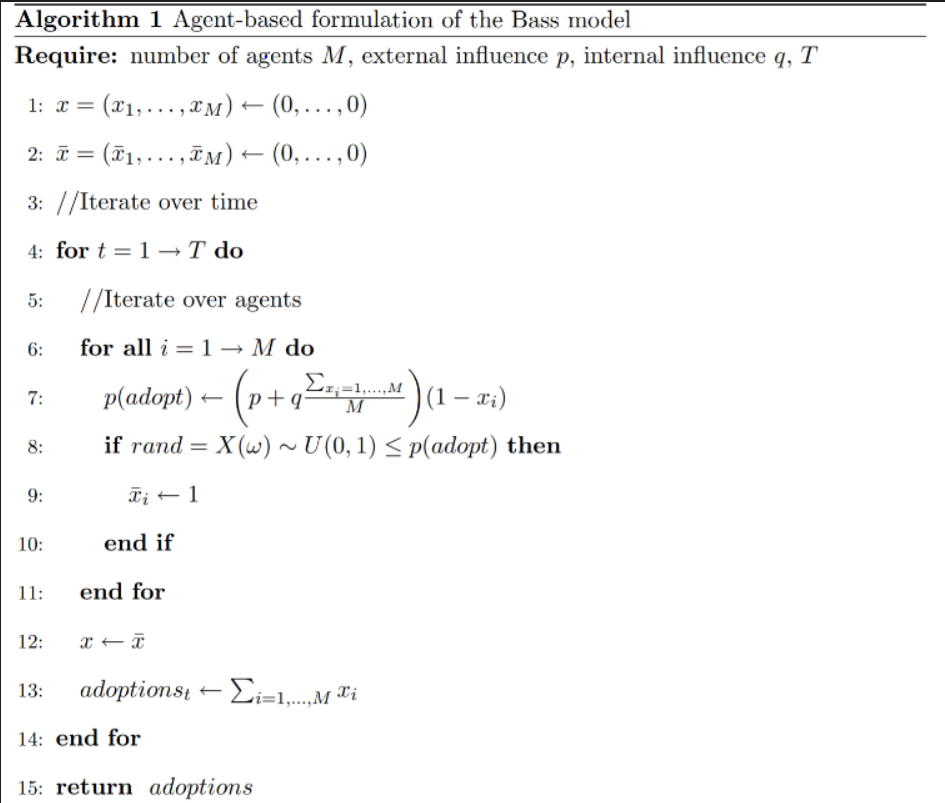

In [9]:
def bass(neighbors:dict, p:float, q:float, T:int):

    M = len(neighbors)
    x = np.zeros(M)
    unifs = np.random.uniform(size=T*M)
    slicer = np.array([0, M])
    adoptions = np.zeros(T)
    all_agents = np.arange(0, M)
    agents = np.random.choice(all_agents, replace=True, size=T*M)

    for t in range(T):

        u = unifs[slicer[0]:slicer[1]]
        agents_cur = agents[slicer[0]:slicer[1]]
        slicer += M
    
        for i in range(M): 

            agent = agents_cur[i]
            # print(agent)
            agent_neighbors = neighbors[agent]
            # print(agent_neighbors)
            adapted_neighbors = sum(x[agent_neighbors])
            # print(adapted_neighbors)
            if len(agent_neighbors) == 0:
                Fi = 0
            else:
                Fi = adapted_neighbors / len(agent_neighbors)
            # print(Fi)
            p_adopt = p + q * Fi

            if u[i] <= p_adopt:
                x[agent] = 1

        adoptions[t] = np.sum(x)
    
    return adoptions


In [49]:
ps = [0.01, 0.03, 0.05]
qs = [0.1, 0.3, 0.5]
params = list(product(ps, qs))
rows = [0, 1, 2]
cols = [0, 1, 2]
axes = list(product(rows, cols))

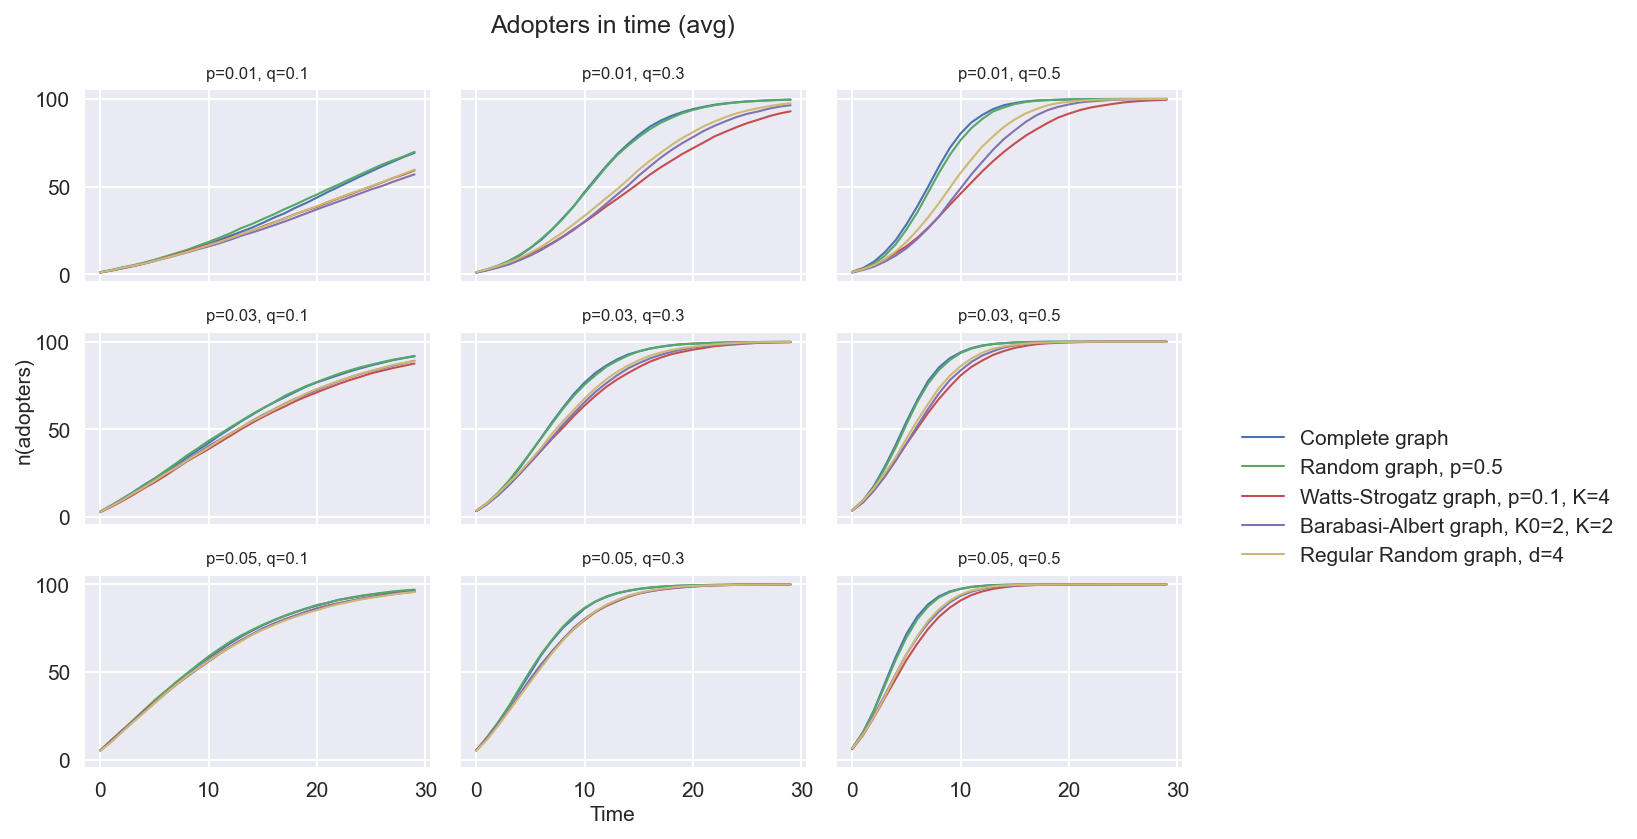

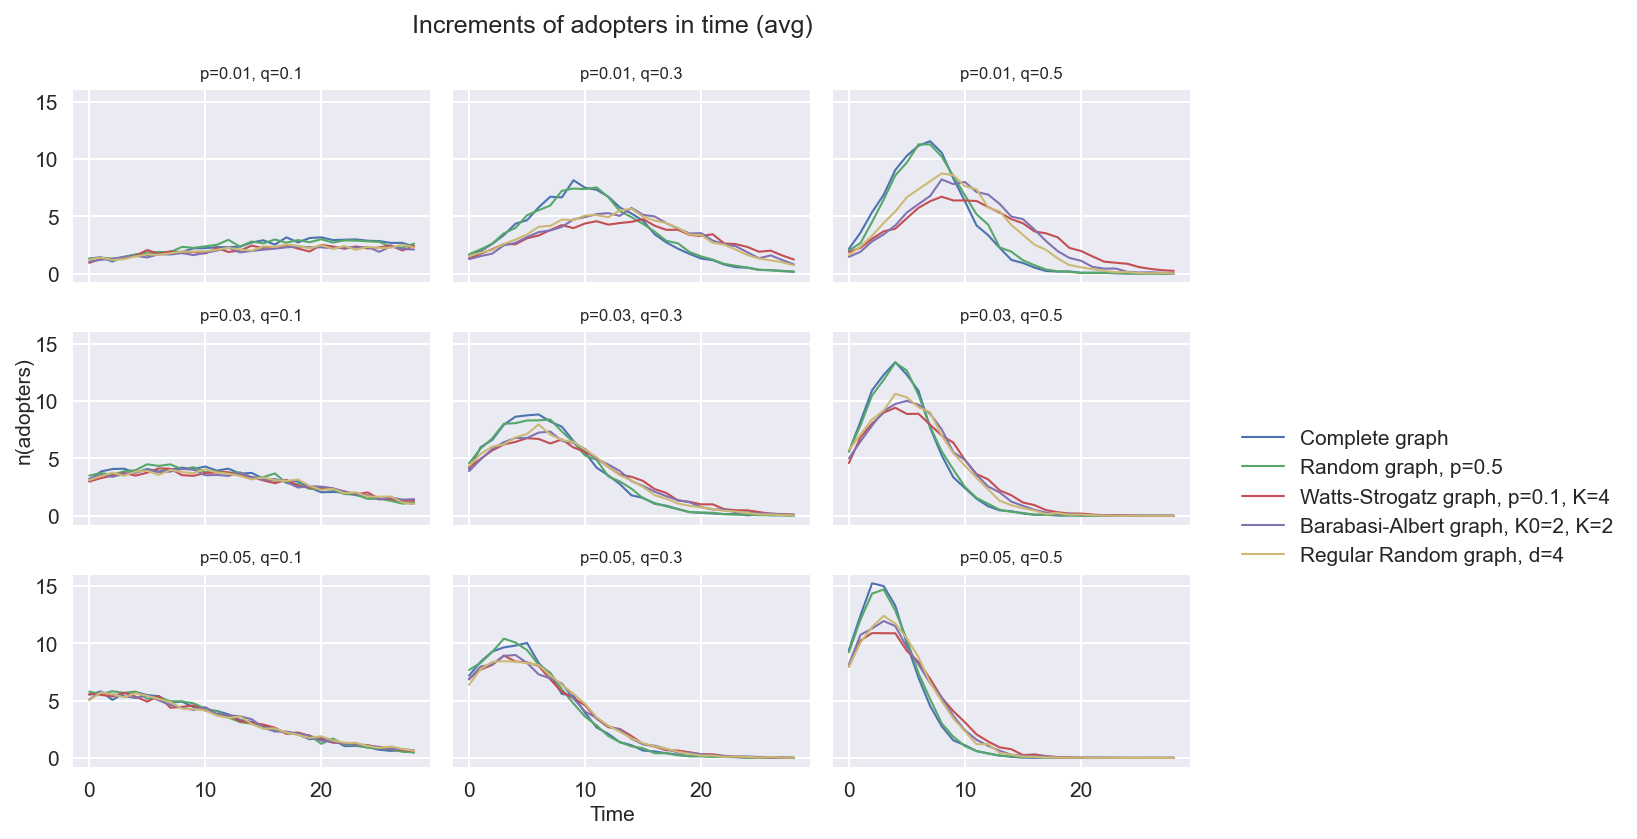

In [59]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(3, 3, sharex=True, sharey=True)

for i, par in enumerate(params):
    
    g1 = random_graph(100, 1)
    b1 = bass(g1, par[0], par[1], 30)
    b1_diff = np.diff(b1)
    g2 = random_graph(100, 0.3)
    b2 = bass(g2, par[0], par[1], 30)
    b2_diff = np.diff(b2)
    g3 = watts_strogatz(100, 0.1, 4)
    b3 = bass(g3, par[0], par[1], 30)
    b3_diff = np.diff(b3)
    g4 = barabasi_albert(100, 2, 2)
    b4 = bass(g4, par[0], par[1], 30)
    b4_diff = np.diff(b4)
    g5 = regular_random_graph(100, 4)
    b5 = bass(g5, par[0], par[1], 30)
    b5_diff = np.diff(b5)

    for _ in range(100):
        b1_new = bass(g1, par[0], par[1], 30)
        b1_diff_new = np.diff(b1_new)
        b1 = np.vstack((b1, b1_new))
        b1_diff = np.vstack((b1_diff, b1_diff_new))
        g2 = random_graph(100, 0.3)
        b2_new = bass(g2, par[0], par[1], 30)
        b2_diff_new = np.diff(b2_new)
        b2 = np.vstack((b2, b2_new))
        b2_diff = np.vstack((b2_diff, b2_diff_new))
        g3 = watts_strogatz(100, 0.1, 4)
        b3_new = bass(g3, par[0], par[1], 30)
        b3_diff_new = np.diff(b3_new)
        b3 = np.vstack((b3, b3_new))
        b3_diff = np.vstack((b3_diff, b3_diff_new))
        g4 = barabasi_albert(100, 2, 2)
        b4_new = bass(g4, par[0], par[1], 30)
        b4_diff_new = np.diff(b4_new)
        b4 = np.vstack((b4, b4_new))
        b4_diff = np.vstack((b4_diff, b4_diff_new))
        g5 = regular_random_graph(100, 4)
        b5_new = bass(g5, par[0], par[1], 30)
        b5_diff_new = np.diff(b5_new)
        b5 = np.vstack((b5, b5_new))
        b5_diff = np.vstack((b5_diff, b5_diff_new))

    b1_avg = np.mean(b1, axis=0)
    b2_avg = np.mean(b2, axis=0)
    b3_avg = np.mean(b3, axis=0)
    b4_avg = np.mean(b4, axis=0)
    b5_avg = np.mean(b5, axis=0)

    b1_avg_diff = np.mean(b1_diff, axis=0)
    b2_avg_diff = np.mean(b2_diff, axis=0)
    b3_avg_diff = np.mean(b3_diff, axis=0)
    b4_avg_diff = np.mean(b4_diff, axis=0)
    b5_avg_diff = np.mean(b5_diff, axis=0)

    axs[axes[i][0], axes[i][1]].plot(b1_avg, label='Complete graph', linewidth=1)
    axs[axes[i][0], axes[i][1]].plot(b2_avg, label='Random graph, p=0.5', linewidth=1)
    axs[axes[i][0], axes[i][1]].plot(b3_avg, label='Watts-Strogatz graph, p=0.1, K=4', linewidth=1)
    axs[axes[i][0], axes[i][1]].plot(b4_avg, label='Barabasi-Albert graph, K0=2, K=2', linewidth=1)
    axs[axes[i][0], axes[i][1]].plot(b5_avg, label='Regular Random graph, d=4', linewidth=1)
    axs[axes[i][0], axes[i][1]].set_title(f'p={par[0]}, q={par[1]}', size=8)

    axs2[axes[i][0], axes[i][1]].plot(b1_avg_diff, label='Complete graph', linewidth=1)
    axs2[axes[i][0], axes[i][1]].plot(b2_avg_diff, label='Random graph, p=0.5', linewidth=1)
    axs2[axes[i][0], axes[i][1]].plot(b3_avg_diff, label='Watts-Strogatz graph, p=0.1, K=4', linewidth=1)
    axs2[axes[i][0], axes[i][1]].plot(b4_avg_diff, label='Barabasi-Albert graph, K0=2, K=2', linewidth=1)
    axs2[axes[i][0], axes[i][1]].plot(b5_avg_diff, label='Regular Random graph, d=4', linewidth=1)
    axs2[axes[i][0], axes[i][1]].set_title(f'p={par[0]}, q={par[1]}', size=8)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.35, 0.5))
handles2, labels2 = axs2[0, 0].get_legend_handles_labels()
fig2.legend(handles2, labels2, loc='upper right', bbox_to_anchor=(1.35, 0.5))
fig.suptitle('Adopters in time (avg)')
fig2.suptitle('Increments of adopters in time (avg)')
fig.text(0.5, 0.01, 'Time', ha='center', va='center')
fig.text(0.01, 0.5, 'n(adopters)', ha='center', va='center', rotation='vertical')
fig2.text(0.5, 0.01, 'Time', ha='center', va='center')
fig2.text(0.01, 0.5, 'n(adopters)', ha='center', va='center', rotation='vertical')
fig.tight_layout()
fig2.tight_layout()
plt.show()